## Creating a Hybrid-Based Book Recommendation model

In [1]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import KNNImputer
import warnings as w
w.filterwarnings('ignore')

### STEP 1: Loading and pre-processing the data


In [2]:
book_df = pd.read_csv(r"C:\Users\konch\Downloads\archive (1)\Books.csv")
rt_df = pd.read_csv(r"C:\Users\konch\Downloads\archive (1)\Ratings.csv")
user_df = pd.read_csv(r"C:\Users\konch\Downloads\archive (1)\Users.csv")

In [3]:
book_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
book_df = book_df[['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher']]

In [5]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


In [6]:
book_df['Year-Of-Publication'] = pd.to_numeric(book_df['Year-Of-Publication'], errors='coerce')


In [7]:
book_df = book_df.dropna()

In [8]:
sorted_years = book_df['Year-Of-Publication'].value_counts().index.values
sorted_years = sorted(sorted_years, reverse=True)

In [9]:
sorted_years

[2050.0,
 2038.0,
 2037.0,
 2030.0,
 2026.0,
 2024.0,
 2021.0,
 2020.0,
 2012.0,
 2011.0,
 2010.0,
 2008.0,
 2006.0,
 2005.0,
 2004.0,
 2003.0,
 2002.0,
 2001.0,
 2000.0,
 1999.0,
 1998.0,
 1997.0,
 1996.0,
 1995.0,
 1994.0,
 1993.0,
 1992.0,
 1991.0,
 1990.0,
 1989.0,
 1988.0,
 1987.0,
 1986.0,
 1985.0,
 1984.0,
 1983.0,
 1982.0,
 1981.0,
 1980.0,
 1979.0,
 1978.0,
 1977.0,
 1976.0,
 1975.0,
 1974.0,
 1973.0,
 1972.0,
 1971.0,
 1970.0,
 1969.0,
 1968.0,
 1967.0,
 1966.0,
 1965.0,
 1964.0,
 1963.0,
 1962.0,
 1961.0,
 1960.0,
 1959.0,
 1958.0,
 1957.0,
 1956.0,
 1955.0,
 1954.0,
 1953.0,
 1952.0,
 1951.0,
 1950.0,
 1949.0,
 1948.0,
 1947.0,
 1946.0,
 1945.0,
 1944.0,
 1943.0,
 1942.0,
 1941.0,
 1940.0,
 1939.0,
 1938.0,
 1937.0,
 1936.0,
 1935.0,
 1934.0,
 1933.0,
 1932.0,
 1931.0,
 1930.0,
 1929.0,
 1928.0,
 1927.0,
 1926.0,
 1925.0,
 1924.0,
 1923.0,
 1922.0,
 1921.0,
 1920.0,
 1919.0,
 1917.0,
 1914.0,
 1911.0,
 1910.0,
 1909.0,
 1908.0,
 1906.0,
 1904.0,
 1902.0,
 1901.0,
 1900.0,
 

Some Years of publication seem to be all over the place like 0 or even in the future, so let's bring it to a more sensible span

In [10]:
invalid_isbns = book_df[(book_df['Year-Of-Publication'] > 2023) | (book_df['Year-Of-Publication'] < 1800)]['ISBN']

In [11]:
rt_df = rt_df[~rt_df['ISBN'].isin(invalid_isbns)]


In [12]:
book_df = book_df[(book_df['Year-Of-Publication'] <= 2023) & (book_df['Year-Of-Publication'] >= 1800)]

In [13]:
rt_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [14]:
rt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135715 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1135715 non-null  int64 
 1   ISBN         1135715 non-null  object
 2   Book-Rating  1135715 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 34.7+ MB


In [15]:
user_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


We'll only keep the country from the Location column

In [16]:
pattern = r'[^,]+,[^,]+,([^,]+)'

In [17]:
user_df['Location'] = user_df['Location'].str.extract(pattern)


In [18]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  273953 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [19]:
user_df = user_df.drop('Age', axis=1)

### STEP 2: EDA

In [20]:
unique_ratings = rt_df['Book-Rating'].value_counts()

In [21]:
print("Unique Ratings and Frequencies:")
print(unique_ratings)

Unique Ratings and Frequencies:
0     707853
8     102298
10     77609
7      75382
9      66654
5      50350
6      36410
4       8779
3       5912
2       2718
1       1750
Name: Book-Rating, dtype: int64


In recommendation systems, implicit feedback is common. A 0 rating often denotes a missing or unknown rating, treated as "implicit negative feedback." This means users without a rating may not necessarily dislike the item; they might just not have expressed an opinion. To not get skewed ratings, we'll proceed with the EDA phase without taking into account any 0 ratings. I would like to keep them for the Recommender system training but unfortunately due to memory constraints I'll be forced to dump them there as well.

In [22]:
rt_df_no_0 = rt_df[rt_df['Book-Rating'] != 0]

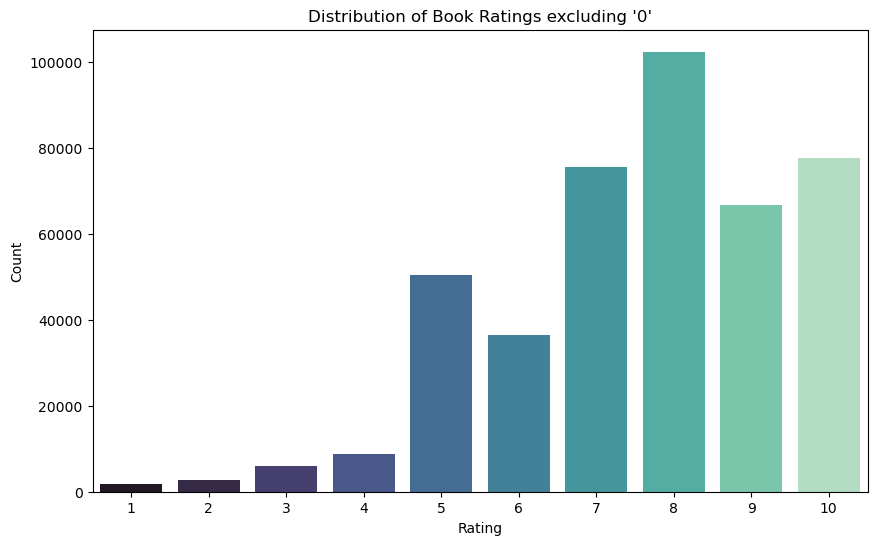

In [23]:
plt.figure(figsize=(10, 6))  
sns.barplot(x=rt_df_no_0['Book-Rating'].value_counts().index, 
            y=rt_df_no_0['Book-Rating'].value_counts().values, palette='mako')
plt.title("Distribution of Book Ratings excluding '0'")
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

In [24]:
merged_df = pd.merge(rt_df_no_0, book_df[['ISBN', 'Book-Title']], on='ISBN', how='inner')

In [25]:
merged_df.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,276726,0155061224,5,Rites of Passage
1,276729,052165615X,3,Help!: Level 1
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...
3,276744,038550120X,7,A Painted House
4,11676,038550120X,10,A Painted House


Text(0, 0.5, 'Title')

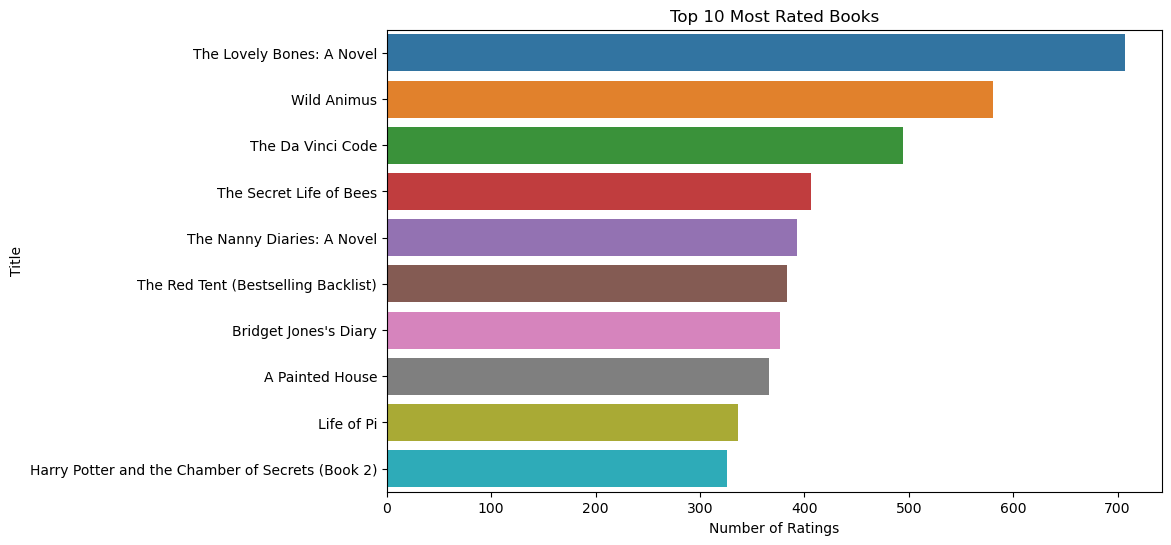

In [26]:
top_rated_books = merged_df['Book-Title'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))  
sns.barplot(x=top_rated_books, y=top_rated_books.index, palette='tab10')
plt.title('Top 10 Most Rated Books')
plt.xlabel('Number of Ratings')
plt.ylabel('Title')

In [27]:
votes_per_book = merged_df.groupby('Book-Title')['User-ID'].count()
popular_books = votes_per_book[votes_per_book > 100].index


In [28]:
average_ratings = merged_df.groupby('Book-Title')['Book-Rating'].mean()


In [29]:
average_ratings = average_ratings.loc[popular_books]


In [30]:
top_books = average_ratings.nlargest(10)


Text(0, 0.5, 'Title')

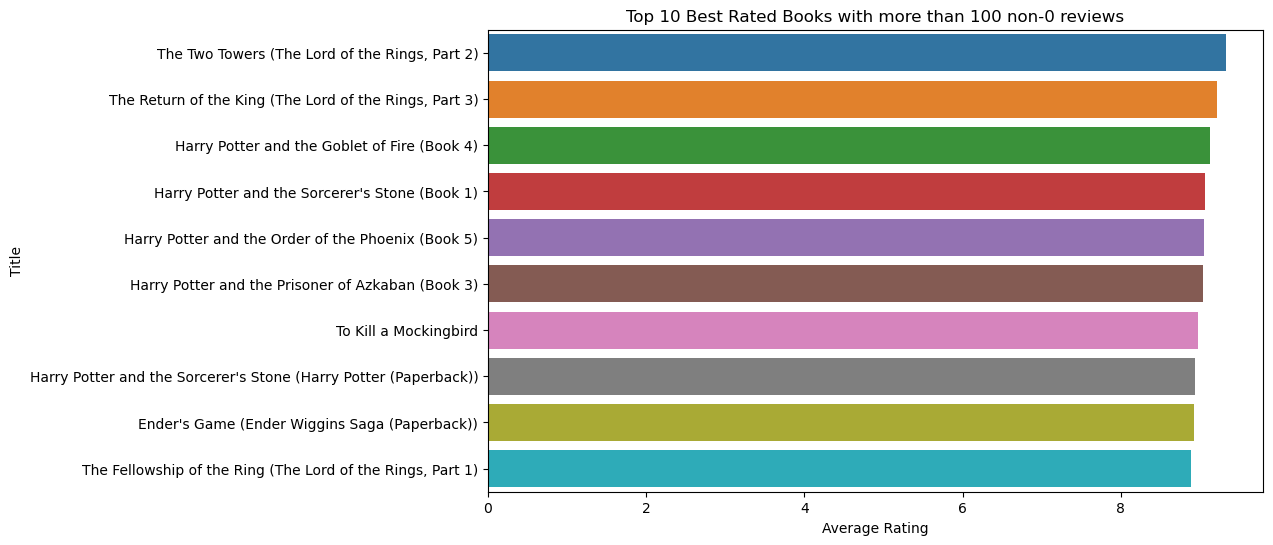

In [31]:

plt.figure(figsize=(10, 6))  
sns.barplot(x=top_books, y=top_books.index, palette='tab10')
plt.title('Top 10 Best Rated Books with more than 100 non-0 reviews')
plt.xlabel('Average Rating')
plt.ylabel('Title')

Text(0, 0.5, 'Country')

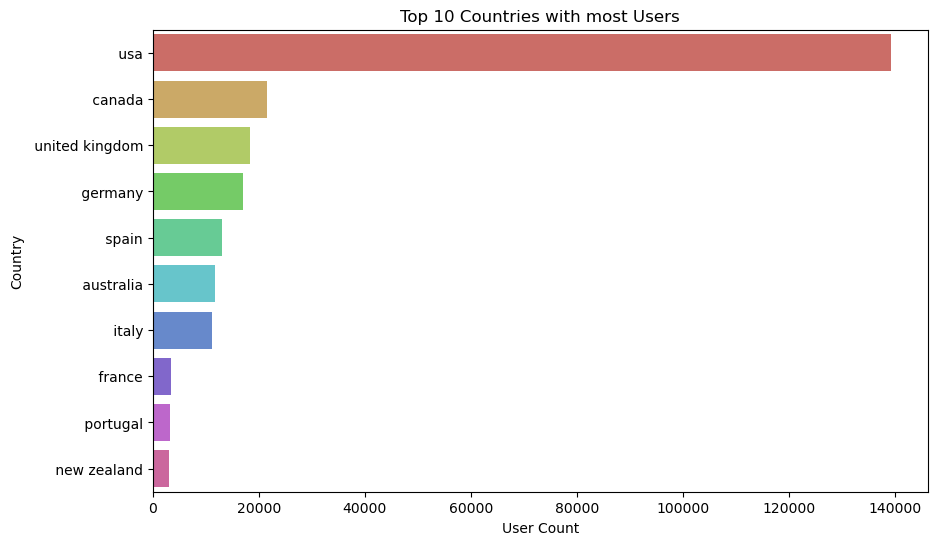

In [32]:
top_user_df = user_df['Location'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))  
sns.barplot(x=top_user_df, y=top_user_df.index, palette='hls')
plt.title('Top 10 Countries with most Users')
plt.xlabel('User Count')
plt.ylabel('Country')

### STEP 3: User-Based Collaborative Filtering

NOTE: Due to hardware issues I'll be forced to work with a filtered sample of the dataset from now on. Thus, we need to make the best use out of the sample. So we'll remove all books with less than 5 non-0 ratings to filter out less popular books

In [33]:
ratings_per_book = merged_df['ISBN'].value_counts()
books_to_drop = ratings_per_book[ratings_per_book < 5].index
filtered_merged_df = merged_df[~merged_df['ISBN'].isin(books_to_drop)]


In [34]:
filtered_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190043 entries, 3 to 352528
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      190043 non-null  int64 
 1   ISBN         190043 non-null  object
 2   Book-Rating  190043 non-null  int64 
 3   Book-Title   190043 non-null  object
dtypes: int64(2), object(2)
memory usage: 7.2+ MB


In [35]:
df_sample = filtered_merged_df.sample(n=65000, random_state=101)

In [36]:
user_item_matrix = df_sample.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating')


In [37]:
user_item_matrix = user_item_matrix.fillna(0)

In [38]:
user_similarities = cosine_similarity(user_item_matrix)


STEP 4: Content-Based Filtering

In [39]:
filtered_books = df_sample['Book-Title'].tolist()

In [40]:
filtered_book_df = book_df[book_df['Book-Title'].isin(filtered_books)]


In [41]:
filtered_book_df = filtered_book_df.reset_index(drop=True)

In [42]:

filtered_book_df['Book-Author'] = filtered_book_df['Book-Author'].fillna('')
filtered_book_df['Publisher'] = filtered_book_df['Publisher'].fillna('')
filtered_book_df['Features'] = filtered_book_df['Book-Author'] + ' ' + filtered_book_df['Publisher']




In [43]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_book_df['Features'])



In [44]:
content_similarity = cosine_similarity(tfidf_matrix)



In [45]:
def get_content_based_recommendations(book_title, content_similarity_matrix, top_n=5):
    book_idx = filtered_book_df[filtered_book_df['Book-Title'] == book_title].index[0]
    similar_books = content_similarity_matrix[book_idx]
    similar_books_idx = np.argsort(similar_books)[::-1][1:top_n+1]
    return filtered_book_df['Book-Title'].iloc[similar_books_idx].tolist()

In [51]:
def get_hybrid_recommendations(user_id, user_similarity_matrix, content_similarity_matrix, top_n=10):
    user_id = np.where(user_item_matrix.index == user_id)[0][0]
    similar_users_idx = np.argsort(user_similarity_matrix[user_id])[::-1][1:top_n+1]
    books_rated_by_similar_users = user_item_matrix.iloc[similar_users_idx].replace(0, np.nan)
    avg_ratings = books_rated_by_similar_users.mean()
    recommended_books = avg_ratings.sort_values(ascending=False)[:top_n].index.tolist()

    hybrid_scores = {}
    for book_title in recommended_books:
        content_recs = get_content_based_recommendations(book_title, content_similarity_matrix, top_n=top_n)
        content_score = content_recs.index(book_title) + 1 if book_title in content_recs else top_n + 1
        user_score = avg_ratings[book_title] if book_title in avg_ratings else 0
        
        hybrid_scores[book_title] = 0.75 * user_score + 0.25 * (1/content_score)
    
    hybrid_recommendations = sorted(hybrid_scores, key=hybrid_scores.get, reverse=True)[:top_n]
    
    return hybrid_recommendations



Example Usage of final function

In [57]:
def print_long_message(message, max_line_length=80):
    for i in range(0, len(message), max_line_length):
        print(message[i:i+max_line_length])

In [60]:
user_id =  260597 
hybrid_recommendations = get_hybrid_recommendations(user_id, user_similarities, content_similarity)
print_long_message(f'Books Recommended: {hybrid_recommendations}')


Books Recommended: ["Are You There God?  It's Me, Margaret", 'The Bridges of Mad
ison County', 'Hot Ice', "She's Come Undone", 'DEAD BY SUNSET : DEAD BY SUNSET',
 'Key of Knowledge (Key Trilogy (Paperback))', 'Raven (Orphans)', 'Storm Front (
The Dresden Files, Book 1)', 'Revenge of the Cootie Girls: A Robin Hudson Myster
y (Robin Hudson Mysteries (Paperback))', 'The Princess Diaries']


In [59]:
#Can find User Ids here
df_sample['User-ID'].tail(10).reset_index()

,index,User-ID
0,117596,40943
1,164556,16263
2,130658,170869
3,2643,107021
4,135603,258534
5,164560,171623
6,85342,123883
7,145197,81207
8,139913,260597
9,51245,45184
